# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape

(891221, 85)

In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [7]:
feat_info.shape

(85, 4)

In [8]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [9]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,SEMIO_LUST,person,ordinal,[-1]
freq,1,43,49,26


In [10]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [11]:
#no.of null
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [12]:
#total no.of null 
num_null = sum(azdias.isnull().sum())
num_null

4896838

In [13]:
# Identify missing or unknown data values and convert them to NaNs.
columns = azdias.columns
for c in columns:
    for i in feat_info['missing_or_unknown']:
        missing_unknow = i[1:-1].split(',')
        if missing_unknow != ['']:
            add = []
            for a in missing_unknow:
                if a in ["X", "XX"]:
                    add.append(a)
                else:
                    add.append(int(a))
            azdias[c] = azdias[c].replace(add, np.nan)

In [14]:
azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,NaN,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,NaN,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,NaN,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,NaN,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [15]:
#no.of NaN
azdias.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP           65468
GREEN_AVANTGARDE         715996
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN      110698
LP_LEBENSPHASE_GROB      143510
LP_FAMILIE_FEIN           88940
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN           148092
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    141734
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [16]:
#total no.of NaN 
num_null = sum(azdias.isnull().sum())
num_null

14880021

In [17]:
#saving to new csv
azdias.to_csv('azdias_new.csv',sep=';',index=False)
#reading the new csv
azdias_new = pd.read_csv('azdias_new.csv',sep=';')

In [18]:
azdias_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null float64
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              498903 non-null float64
GFK_URLAUBERTYP          825753 non-null float64
GREEN_AVANTGARDE         175225 non-null float64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      780523 non-null float64
LP_LEBENSPHASE_GROB      747711 non-null float64
LP_FAMILIE_FEIN          802281 non-null float64
LP_FAMILIE_GROB        

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

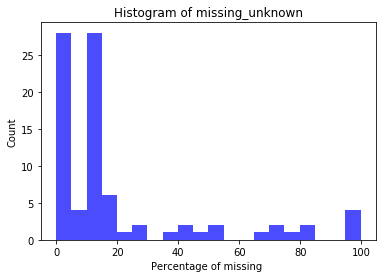

In [19]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
miss = azdias_new.isnull().sum()
miss = miss/azdias_new.shape[0]*100
miss.sort_values(inplace=True)

plt.hist(miss, bins=20, facecolor='blue', alpha=0.7)
plt.ylabel('Count')
plt.xlabel('Percentage of missing ')
plt.title('Histogram of missing_unknown')
plt.show();

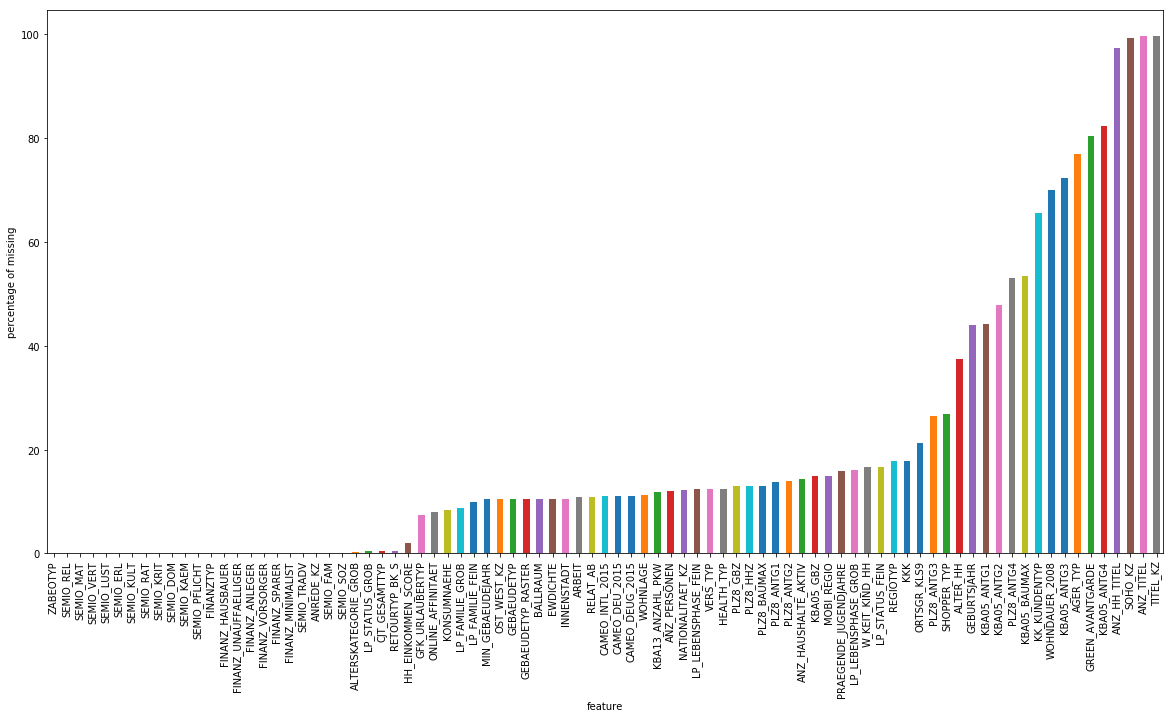

In [20]:
miss.plot.bar(figsize=(20,10))
plt.xlabel('feature')
plt.ylabel('percentage of missing')
plt.show();

In [21]:
# Investigate patterns in the amount of missing data in each column.

#percentage of missing data in each column
miss

ZABEOTYP                  0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT                0.000000
SEMIO_LUST                0.000000
SEMIO_ERL                 0.000000
SEMIO_KULT                0.000000
SEMIO_RAT                 0.000000
SEMIO_KRIT                0.000000
SEMIO_DOM                 0.000000
SEMIO_KAEM                0.000000
SEMIO_PFLICHT             0.000000
FINANZTYP                 0.000000
FINANZ_HAUSBAUER          0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_ANLEGER            0.000000
FINANZ_VORSORGER          0.000000
FINANZ_SPARER             0.000000
FINANZ_MINIMALIST         0.000000
SEMIO_TRADV               0.000000
ANREDE_KZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_SOZ                 0.000000
ALTERSKATEGORIE_GROB      0.323264
LP_STATUS_GROB            0.544646
CJT_GESAMTTYP             0.544646
RETOURTYP_BK_S            0.544646
HH_EINKOMMEN_SCORE        2.058749
GFK_URLAUBERTYP     

In [22]:
null = pd.DataFrame(azdias_new.isnull().sum(),columns=['num'])
null = null.reset_index()
null.columns = ['feature','num']
null['per'] = null['num']/azdias_new.shape[0]*100

null

,feature,num,per
0,AGER_TYP,685843,76.955435
1,ALTERSKATEGORIE_GROB,2881,0.323264
2,ANREDE_KZ,0,0.000000
3,CJT_GESAMTTYP,4854,0.544646
4,FINANZ_MINIMALIST,0,0.000000
5,FINANZ_SPARER,0,0.000000
6,FINANZ_VORSORGER,0,0.000000
7,FINANZ_ANLEGER,0,0.000000
8,FINANZ_UNAUFFAELLIGER,0,0.000000
9,FINANZ_HAUSBAUER,0,0.000000


In [23]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#removing outlier columns  which are over 20%
over_20 = null.query('per >= 20')
for i in over_20.feature:
    azdias_new.drop(i, axis=1, inplace=True)


In [24]:
azdias_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 66 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GFK_URLAUBERTYP          825753 non-null float64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      780523 non-null float64
LP_LEBENSPHASE_GROB      747711 non-null float64
LP_FAMILIE_FEIN          802281 non-null float64
LP_FAMILIE_GROB          813429 non-null float64
LP_STATUS_FEIN           743129 non-null float64
LP_STATUS_GROB           886367 non-null float64
NATIONALITAET_KZ       

#### Discussion 1.1.2: Assess Missing Data in Each Column

From the 'null' data frame we can infer that there are many columns that have lost most of their data and the columns are outliers.
So, I decided to delete columns that have lost more than 20% of the data.
The missing data maybe personal information that people don't want to share, such as family information. For example, the PLZ8 macro_cell feature. It's all about the type of buildings and family homes in the area a person lives in.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

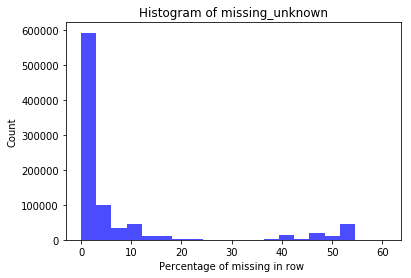

In [25]:
# How much data is missing in each row of the dataset?

miss_row = azdias_new.isnull().sum(axis=1)
miss_row = miss_row/len(azdias_new.columns)*100
miss_row.sort_values(inplace=True)

plt.hist(miss_row, bins=20, facecolor='blue', alpha=0.7)
plt.ylabel('Count')
plt.xlabel('Percentage of missing in row ')
plt.title('Histogram of missing_unknown')
plt.show();

In [26]:
len(azdias_new.columns)

66

In [27]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

low_miss = azdias_new[azdias_new.isnull().sum(axis=1) <= 5].reset_index(drop=True)
high_miss = azdias_new[azdias_new.isnull().sum(axis=1) > 5].reset_index(drop=True)

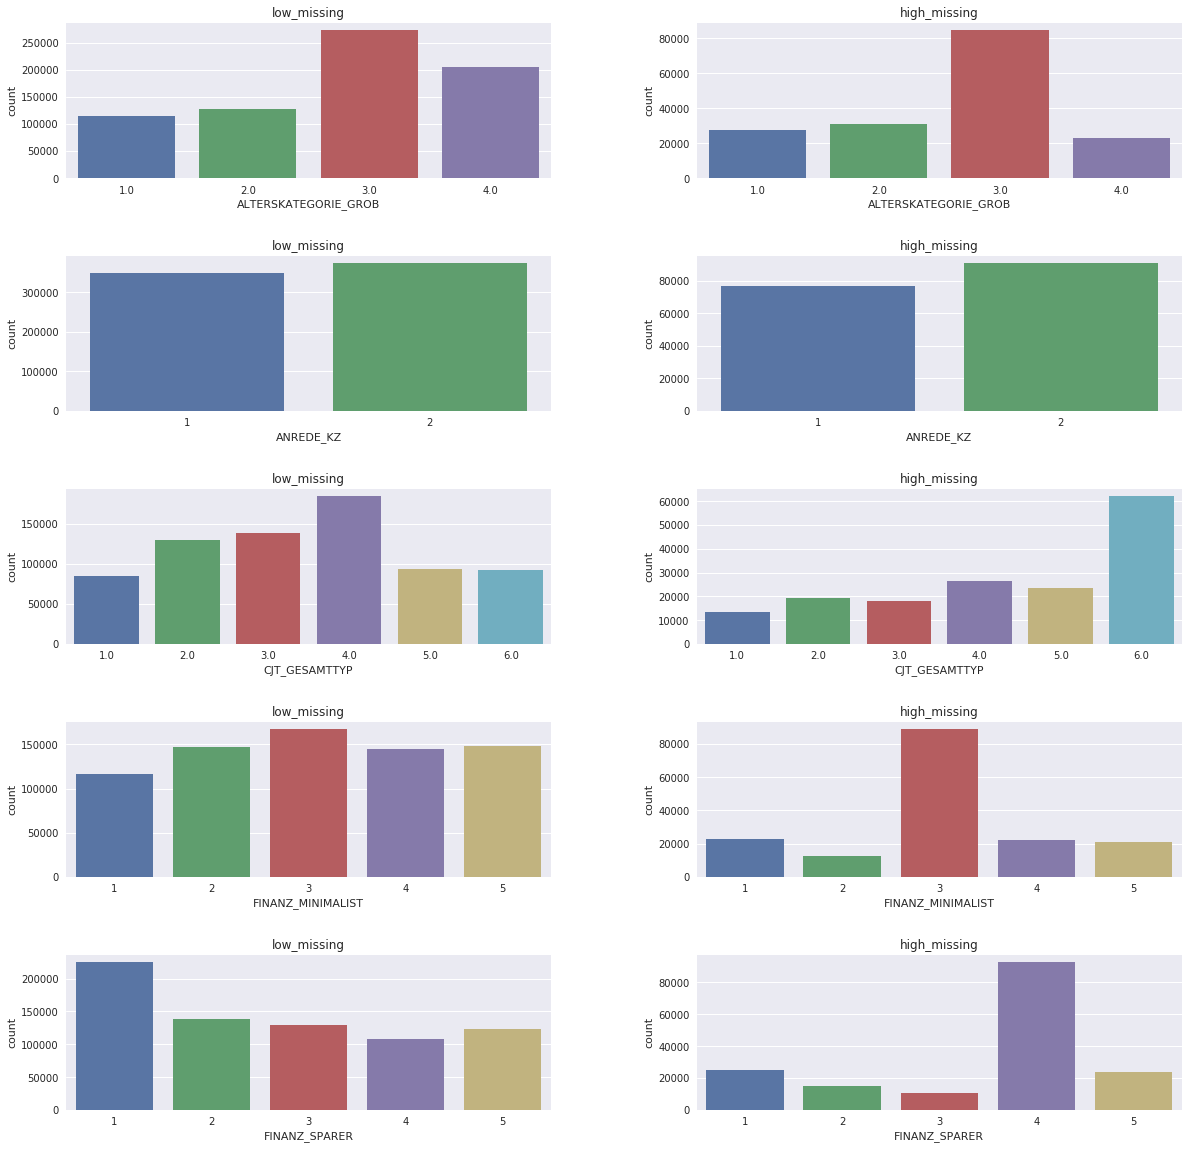

In [28]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_plot(n):
    sns.set(style='darkgrid')
    fig, axs = plt.subplots(n,2,figsize=(20, 20))
    fig.subplots_adjust(hspace=.5, wspace=.3)
    axs = axs.ravel()
    col = low_miss.columns
    
    for i in range(n):
        sns.countplot(low_miss[col[i]], ax=axs[2*i])
        axs[2*i].set_title('low_missing')
        sns.countplot(high_miss[col[i]], ax=axs[2*i+1])
        axs[2*i+1].set_title('high_missing')
compare_plot(5)

In [29]:
#fill nan with columns' mode
for i in azdias_new.columns:
    azdias_new[i] = azdias_new[i].fillna(azdias_new[i].mode()[0])

#### Discussion 1.1.3: Assess Missing Data in Each Row

I observed the following five data features:
- ALTERSKATEGORIE_GROB
- ANREDE_KZ
- CJT_GESAMTTYP
- FINANZ_MINIMALIST
- FINANZ_SPARER

Of these data features, ALTERSKATEGORIE_GROB and ANREDE_KZ are evenly distributed between the two data sets, while CJT_GESAMTTYP, FINANZ_MINIMALIST and FINANZ_SPARER are unevenly distributed.

It seems that many features are very differently distributed between the two data sets(high NaN data and low NaN data). This means that deleting all columns that contains NaN may not be the best way because it may break the original data. The quality of the data should be improved. For example, using mode to replace the missing value.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [30]:
# How many features are there of each data type?

dic = {}
for i in feat_info['type']:
    if i in dic:
        dic[i] += 1
    else:
        dic[i] = 1

dic

{'categorical': 21, 'ordinal': 49, 'numeric': 7, 'mixed': 7, 'interval': 1}

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [31]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

feat_info.set_index('attribute', inplace=True)
def get_dir(df):
    binary = {}
    multi_level = {}
    mixed = {}
    for i in df.columns:
        if feat_info.loc[i].type == 'categorical':
            n = df[i].nunique()
            if n > 2:
                multi_level[i] = [df[i].nunique(), df[i].dtype]
            else:
                binary[i] = [df[i].nunique(), df[i].dtype]
            
        elif feat_info.loc[i].type == 'mixed':
            mixed[i] = [df[i].nunique(), df[i].dtype]

    return binary, multi_level, mixed

In [32]:
binary, multi_level, mixed = get_dir(azdias_new)

In [33]:
binary

{'ANREDE_KZ': [2, dtype('int64')],
 'VERS_TYP': [2, dtype('float64')],
 'OST_WEST_KZ': [2, dtype('O')]}

In [34]:
multi_level

{'CJT_GESAMTTYP': [6, dtype('float64')],
 'FINANZTYP': [6, dtype('int64')],
 'GFK_URLAUBERTYP': [11, dtype('float64')],
 'LP_FAMILIE_FEIN': [10, dtype('float64')],
 'LP_FAMILIE_GROB': [5, dtype('float64')],
 'LP_STATUS_FEIN': [9, dtype('float64')],
 'LP_STATUS_GROB': [5, dtype('float64')],
 'NATIONALITAET_KZ': [3, dtype('float64')],
 'ZABEOTYP': [6, dtype('int64')],
 'GEBAEUDETYP': [7, dtype('float64')],
 'CAMEO_DEUG_2015': [9, dtype('float64')],
 'CAMEO_DEU_2015': [44, dtype('O')]}

In [35]:
mixed

{'LP_LEBENSPHASE_FEIN': [39, dtype('float64')],
 'LP_LEBENSPHASE_GROB': [11, dtype('float64')],
 'PRAEGENDE_JUGENDJAHRE': [14, dtype('float64')],
 'WOHNLAGE': [7, dtype('float64')],
 'CAMEO_INTL_2015': [21, dtype('float64')],
 'PLZ8_BAUMAX': [5, dtype('float64')]}

In [36]:
# Re-encode categorical variable(s) to be kept in the analysis.

azdias_new['OST_WEST_KZ'] = azdias_new['OST_WEST_KZ'].replace('W', 1)
azdias_new['OST_WEST_KZ'] = azdias_new['OST_WEST_KZ'].replace('O', 0)

In [37]:
# drop all columns of multi_level 
for i in multi_level:
    azdias_new.drop(i, axis=1, inplace=True)

#### Discussion 1.2.1: Re-Encode Categorical Features

Binary：
- ANREDE_KZ
- VERS_TYP
- OST_WEST_KZ

Multi level：
- CJT_GESAMTTYP
- FINANZTYP
- GFK_URLAUBERTYP
- LP_FAMILIE_FEIN
- LP_FAMILIE_GROB
- LP_STATUS_FEIN
- LP_STATUS_GROB
- NATIONALITAET_KZ
- ZABEOTYP
- GEBAEUDETYP
- CAMEO_DEUG_2015
- CAMEO_DEU_2015

Mixed：
- LP_LEBENSPHASE_FEIN
- LP_LEBENSPHASE_GROB
- PRAEGENDE_JUGENDJAHRE
- WOHNLAGE
- CAMEO_INTL_2015
- PLZ8_BAUMAX

I kept these features: ANREDE_KZ, VERS_TYP, OST_WEST_KZ and re-encoded OST_WEST_KZ. 
I droped all multi level features in data.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [38]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
#Create movement
#Mainstream--1, Avantgarde--2
azdias_new.loc[azdias_new['PRAEGENDE_JUGENDJAHRE'].isin([1, 3, 5, 8, 10, 12, 14]), 'movement'] = 1
azdias_new.loc[azdias_new['PRAEGENDE_JUGENDJAHRE'].isin([2, 4, 6, 7, 9, 11, 13, 15]), 'movement'] = 2

In [39]:
#Create nation
#E--1, W--2, W+E--3
azdias_new.loc[azdias_new['PRAEGENDE_JUGENDJAHRE'].isin([7, 12, 13]),'nation'] = 1
azdias_new.loc[azdias_new['PRAEGENDE_JUGENDJAHRE'].isin([6, 10, 11]), 'nation'] = 2
azdias_new.loc[azdias_new['PRAEGENDE_JUGENDJAHRE'].isin([1, 2, 3, 4, 5, 8, 9, 14, 15]), 'nation'] = 3

In [40]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
#Create wealth 
#Wealthy Households--1, Prosperous Households--2, Comfortable Households--3, Less Affluent Households--4, Poorer Households--5
azdias_new.loc[azdias_new['CAMEO_INTL_2015'].isin([11, 12, 13, 14, 15]), 'wealth'] = 1
azdias_new.loc[azdias_new['CAMEO_INTL_2015'].isin([21, 22, 23, 24, 25]), 'wealth'] = 2
azdias_new.loc[azdias_new['CAMEO_INTL_2015'].isin([31, 32, 33, 34, 35]), 'wealth'] = 3
azdias_new.loc[azdias_new['CAMEO_INTL_2015'].isin([41, 42, 43, 44, 45]), 'wealth'] = 4
azdias_new.loc[azdias_new['CAMEO_INTL_2015'].isin([51, 52, 53, 54, 55]), 'wealth'] = 5


#Create life_stage
#Pre-Family Couples & Single--1, Young Couples With Children--2, Families With School Age Children--3, 
#Older Families&Mature Couples--4,  Elders In Retirement--5
azdias_new.loc[azdias_new['CAMEO_INTL_2015'].isin([11, 21, 31, 41, 51]), 'life_stage'] = 1
azdias_new.loc[azdias_new['CAMEO_INTL_2015'].isin([12, 22, 32, 42, 52]), 'life_stage'] = 2
azdias_new.loc[azdias_new['CAMEO_INTL_2015'].isin([13, 23, 33, 43, 53]), 'life_stage'] = 3
azdias_new.loc[azdias_new['CAMEO_INTL_2015'].isin([14, 24, 34, 44, 54]), 'life_stage'] = 4
azdias_new.loc[azdias_new['CAMEO_INTL_2015'].isin([15, 25, 35, 45, 55]), 'life_stage'] = 5


In [41]:
for i in mixed:
    azdias_new.drop(i, axis=1, inplace=True)

azdias_new.to_csv('cleaned_azdia.csv', sep=';', index=False)

In [42]:
azdias_new.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,RELAT_AB,movement,nation,wealth,life_stage
0,2.0,1,3,4,3,5,5,3,3.0,5.0,...,2.0,3.0,3.0,3.0,4.0,3.0,1.0,3.0,5.0,1.0
1,1.0,2,1,5,2,5,4,5,3.0,1.0,...,2.0,3.0,5.0,4.0,3.0,4.0,1.0,3.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,3.0,3.0,...,3.0,3.0,4.0,4.0,3.0,2.0,2.0,3.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,2.0,2.0,...,2.0,2.0,3.0,4.0,2.0,3.0,1.0,3.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,3.0,5.0,...,2.0,4.0,3.0,3.0,4.0,5.0,1.0,3.0,4.0,3.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

I changed the following columns:
- PRAEGENDE_JUGENDJAHRE to movement
  - Mainstream--1
  - Avantgarde--2
- CAMEO_INTL_201 to wealth
  - Wealthy Households--1
  - Prosperous Households--2
  - Comfortable Households--3
  - Less Affluent Households--4
  - Poorer Households--5
- CAMEO_INTL_201 to life_stage
  - Pre-Family Couples & Single--1
  - Young Couples With Children--2
  - Families With School Age Children--3
  - Older Families&Mature Couples--4
  - Elders In Retirement--5
  
I dropped the following original columns:
- LP_LEBENSPHASE_FEIN
- LP_LEBENSPHASE_GROB
- PRAEGENDE_JUGENDJAHRE
- WOHNLAGE
- PLZ8_BAUMAX

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [43]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

azdias.isnull().sum(axis=1).describe()

count    891221.000000
mean         16.696219
std          12.101065
min           3.000000
25%          11.000000
50%          12.000000
75%          15.000000
max          58.000000
dtype: float64

In [44]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,205378.000000,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,769236.000000,767268.000000,654912.000000,418317.000000,774706.000000,774706.000000,774706.000000,793846.000000,702068.000000,793846.000000
mean,1.743410,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.269353,2.829019,1.887255,1.294827,1.943913,3.612821,3.381087,3.166686,4.808308,3.071033
std,0.674312,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.956637,0.882235,0.775234,0.455965,1.459654,0.973967,1.111598,0.999072,1.991626,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,1.000000,1.000000,1.000000,3.000000,3.000000,3.000000,3.000000,2.000000
50%,2.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,3.000000,2.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,8.000000,5.000000


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [45]:
def get_dir(df):
    binary = {}
    multi_level = {}
    mixed = {}
    for i in df.columns:
        if feat_info.loc[i].type == 'categorical':
            n = df[i].nunique()
            if n > 2:
                multi_level[i] = [df[i].nunique(), df[i].dtype]
            else:
                binary[i] = [df[i].nunique(), df[i].dtype]
            
        elif feat_info.loc[i].type == 'mixed':
            mixed[i] = [df[i].nunique(), df[i].dtype]

    return binary, multi_level, mixed

In [46]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    columns = df.columns
    for c in columns:
        for i in feat_info['missing_or_unknown']:
            missing_unknow = i[1:-1].split(',')
            if missing_unknow != ['']:
                add = []
                for a in missing_unknow:
                    if a in ["X", "XX"]:
                        add.append(a)
                    else:
                        add.append(int(a))
                df[c] = df[c].replace(add, np.nan)
                
    null = pd.DataFrame(df.isnull().sum(),columns=['num'])
    null = null.reset_index()
    null.columns = ['feature','num']
    null['per'] = null['num']/df.shape[0]*100
    over_40 = null.query('per >= 40')
    for i in over_40.feature:
        df.drop(i, axis=1, inplace=True)
        
        
    for i in df.columns:
        df[i] = df[i].fillna(df[i].mode()[0])
        
    binary, multi_level, mixed = get_dir(df)
    
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(np.float64)
    df.loc[df['OST_WEST_KZ']=='W', 'OST_WEST_KZ'] = 1
    df.loc[df['OST_WEST_KZ']=='O', 'OST_WEST_KZ'] = 0
    
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1, 3, 5, 8, 10, 12, 14]), 'movement'] = 1
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([2, 4, 6, 7, 9, 11, 13, 15]), 'movement'] = 2
    
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([7, 12, 13]),'nation'] = 1
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([6, 10, 11]), 'nation'] = 2
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1, 2, 3, 4, 5, 8, 9, 14, 15]), 'nation'] = 3

    df.loc[df['CAMEO_INTL_2015'].isin([11, 12, 13, 14, 15]), 'wealth'] = 1
    df.loc[df['CAMEO_INTL_2015'].isin([21, 22, 23, 24, 25]), 'wealth'] = 2
    df.loc[df['CAMEO_INTL_2015'].isin([31, 32, 33, 34, 35]), 'wealth'] = 3
    df.loc[df['CAMEO_INTL_2015'].isin([41, 42, 43, 44, 45]), 'wealth'] = 4
    df.loc[df['CAMEO_INTL_2015'].isin([51, 52, 53, 54, 55]), 'wealth'] = 5

    df.loc[df['CAMEO_INTL_2015'].isin([11, 21, 31, 41, 51]), 'life_stage'] = 1
    df.loc[df['CAMEO_INTL_2015'].isin([12, 22, 32, 42, 52]), 'life_stage'] = 2
    df.loc[df['CAMEO_INTL_2015'].isin([13, 23, 33, 43, 53]), 'life_stage'] = 3
    df.loc[df['CAMEO_INTL_2015'].isin([14, 24, 34, 44, 54]), 'life_stage'] = 4
    df.loc[df['CAMEO_INTL_2015'].isin([15, 25, 35, 45, 55]), 'life_stage'] = 5
    
    for i in multi_level:
        df.drop(i, axis=1, inplace=True)
        
    for m in mixed:
        df.drop(m, axis=1, inplace=True)
    
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [47]:
azdias = pd.read_csv('cleaned_azdia.csv', sep=';')

In [48]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imp_azdias = pd.DataFrame(imp.fit_transform(azdias), columns = azdias.columns, index = azdias.index)

In [49]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
scaled_azdias = pd.DataFrame(scaler.fit_transform(imp_azdias), columns = imp_azdias.columns, index = imp_azdias.index)

In [50]:
len(azdias.columns)

52

In [51]:
scaled_azdias.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,RELAT_AB,movement,nation,wealth,life_stage
count,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,...,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05
mean,2.500235e-17,1.004638e-16,3.507983e-18,9.879756e-17,5.941247e-17,-3.310260e-17,3.897050e-17,1.505562e-16,-2.028571e-16,8.088292e-17,...,-2.475679e-16,2.026737e-16,1.297156e-16,1.080140e-16,-1.562647e-18,1.161940e-16,-1.591986e-16,-2.286966e-16,1.181552e-17,8.355377e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.743339e+00,-1.045218e+00,-1.570358e+00,-1.243244e+00,-1.816084e+00,-1.329319e+00,-1.260597e+00,-1.533438e+00,-1.708990e+00,-1.711653e+00,...,-1.379285e+00,-2.257523e+00,-2.719611e+00,-2.232324e+00,-2.308299e+00,-1.606600e+00,-4.347214e-01,-3.446343e+00,-1.653917e+00,-1.095866e+00
25%,-7.516797e-01,-1.045218e+00,-8.133868e-01,-1.243244e+00,-3.033778e-01,-6.755539e-01,-5.879796e-01,-7.944745e-01,-3.853969e-01,-1.006758e+00,...,-2.601766e-01,-1.039084e+00,-5.720153e-01,-3.172055e-01,-2.635063e-01,-8.279336e-01,-4.347214e-01,4.743524e-01,-9.804530e-01,-1.095866e+00
50%,2.399800e-01,9.567382e-01,-5.641562e-02,1.221788e-01,-3.033778e-01,-2.178896e-02,8.463740e-02,-5.551131e-02,-3.853969e-01,-3.018624e-01,...,-2.601766e-01,1.793546e-01,-5.720153e-01,-3.172055e-01,-2.635063e-01,-4.926747e-02,-4.347214e-01,4.743524e-01,3.664744e-01,2.210984e-01
75%,1.231640e+00,9.567382e-01,7.005556e-01,8.048901e-01,1.209329e+00,1.285741e+00,7.572544e-01,6.834519e-01,9.381966e-01,1.107928e+00,...,8.589322e-01,1.793546e-01,5.017827e-01,6.403537e-01,7.588900e-01,7.293987e-01,-4.347214e-01,4.743524e-01,1.039938e+00,8.795808e-01
max,1.231640e+00,9.567382e-01,1.457527e+00,1.487601e+00,1.209329e+00,1.285741e+00,1.429871e+00,1.422415e+00,9.381966e-01,1.107928e+00,...,1.978041e+00,1.397794e+00,1.575581e+00,1.597913e+00,1.781286e+00,1.508065e+00,2.300324e+00,4.743524e-01,1.039938e+00,1.538063e+00


### Discussion 2.1: Apply Feature Scaling

I used the mode instead of the mean to replace the NaNs, because in this case, all the numeric variables are interleaved and no floating numbers are generated and I've applied standard scaling to all features.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [52]:
# Apply PCA to the data.

pca = PCA()
pca_azdias = pca.fit_transform(scaled_azdias)

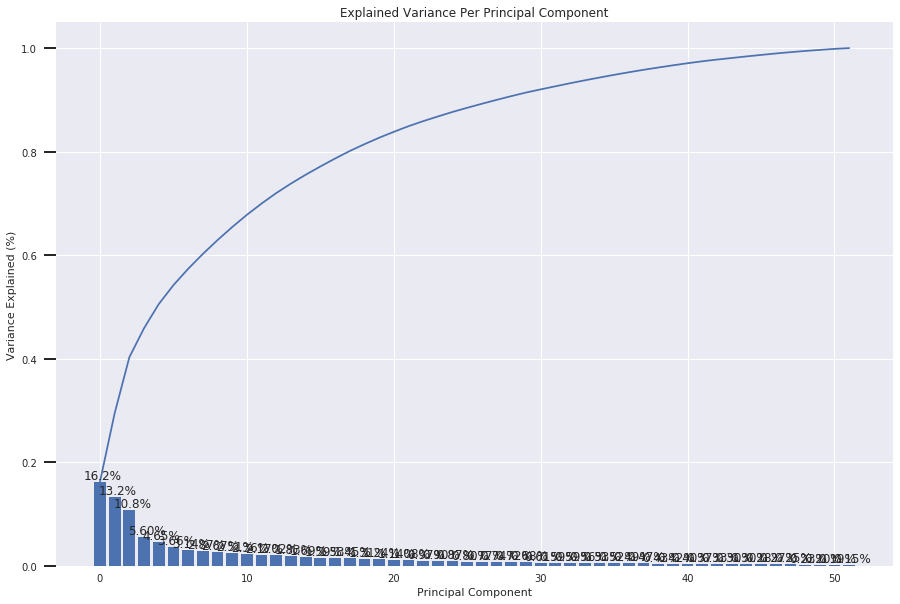

In [53]:
# Investigate the variance accounted for by each principal component.

def screen_plot(pca):
    
    num_components = len(pca.explained_variance_ratio_)
    vals = pca.explained_variance_ratio_
    ind = np.arange(num_components)
    
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
                   #(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title("Explained Variance Per Principal Component")
    
    
screen_plot(pca)

In [54]:
azdias.shape

(891221, 52)

In [55]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=50)
pca_azdias = pca.fit_transform(scaled_azdias)

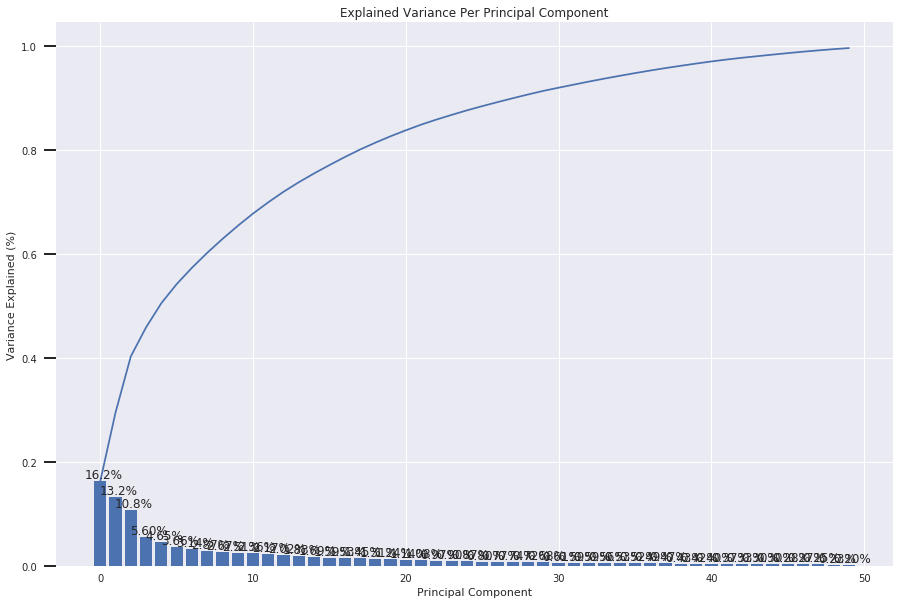

In [56]:
screen_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

From the graphs shown above, we can see that after 50 features, the variance of interpretation tends to be stable  and becomes 1. So I chose 50 features to redo the PCA.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [57]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def wmap(pca, com):
    if com <= len(pca.components_):
        w = {'weight':pca.components_[com],
         'name':azdias.columns}
    
        wmap = pd.DataFrame(w)
        wmap = wmap.sort_values(by='weight',ascending=False)
        print(wmap)
        
    else:
        print('Error')

In [58]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

#pca 1
print(wmap(pca, 0))

      weight                   name
0   0.252742   ALTERSKATEGORIE_GROB
2   0.242922      FINANZ_MINIMALIST
4   0.231583       FINANZ_VORSORGER
16  0.186737              SEMIO_ERL
38  0.186433             MOBI_REGIO
42  0.161214             PLZ8_ANTG1
15  0.150239             SEMIO_LUST
32  0.149063              KBA05_GBZ
29  0.147983            KONSUMNAEHE
51  0.147819             life_stage
45  0.119700               PLZ8_GBZ
9   0.107288         RETOURTYP_BK_S
35  0.101657             INNENSTADT
48  0.085902               movement
14  0.083879             SEMIO_VERT
36  0.072334     GEBAEUDETYP_RASTER
25  0.069183           ANZ_PERSONEN
33  0.050603               BALLRAUM
30  0.032757       MIN_GEBAEUDEJAHR
31  0.011081            OST_WEST_KZ
1  -0.002249              ANREDE_KZ
44 -0.008396               PLZ8_HHZ
49 -0.012329                 nation
27 -0.012586         W_KEIT_KIND_HH
39 -0.016830      ONLINE_AFFINITAET
19 -0.021766             SEMIO_KRIT
41 -0.023011       KBA13_ANZ

In [59]:
#pca 2
print(wmap(pca, 1))

      weight                   name
21  0.232826             SEMIO_KAEM
16  0.212063              SEMIO_ERL
19  0.204344             SEMIO_KRIT
7   0.199472       FINANZ_HAUSBAUER
1   0.193227              ANREDE_KZ
20  0.181449              SEMIO_DOM
34  0.179280               EWDICHTE
50  0.175379                 wealth
0   0.150530   ALTERSKATEGORIE_GROB
43  0.148263             PLZ8_ANTG2
46  0.137960                 ARBEIT
47  0.124878               RELAT_AB
4   0.124430       FINANZ_VORSORGER
15  0.123809             SEMIO_LUST
26  0.123552     HH_EINKOMMEN_SCORE
27  0.122640         W_KEIT_KIND_HH
9   0.108674         RETOURTYP_BK_S
28  0.105612    ANZ_HAUSHALTE_AKTIV
24  0.066969               VERS_TYP
40  0.057947               REGIOTYP
49  0.052248                 nation
37  0.030721                    KKK
44  0.017703               PLZ8_HHZ
8  -0.003195             HEALTH_TYP
41 -0.022500       KBA13_ANZAHL_PKW
31 -0.030535            OST_WEST_KZ
18 -0.049458              SE

In [60]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

#pca 3
print(wmap(pca, 2))

      weight                   name
14  0.292164             SEMIO_VERT
10  0.251095              SEMIO_SOZ
17  0.207382             SEMIO_KULT
11  0.183808              SEMIO_FAM
26  0.136218     HH_EINKOMMEN_SCORE
9   0.135809         RETOURTYP_BK_S
43  0.126198             PLZ8_ANTG2
28  0.118141    ANZ_HAUSHALTE_AKTIV
47  0.117583               RELAT_AB
34  0.114120               EWDICHTE
50  0.108248                 wealth
4   0.102441       FINANZ_VORSORGER
46  0.098664                 ARBEIT
27  0.094910         W_KEIT_KIND_HH
0   0.093128   ALTERSKATEGORIE_GROB
7   0.077777       FINANZ_HAUSBAUER
15  0.062047             SEMIO_LUST
2   0.050214      FINANZ_MINIMALIST
13  0.033595              SEMIO_MAT
44  0.029572               PLZ8_HHZ
12  0.005733              SEMIO_REL
40  0.004036               REGIOTYP
37  0.001169                    KKK
48 -0.004740               movement
49 -0.006779                 nation
24 -0.010294               VERS_TYP
51 -0.030485             lif

### Discussion 2.3: Interpret Principal Components

I looked at several major components of the above dataframe. Those features seems to strongly explain the principal component.

**pca 1**

The first principal component is about age and low financial , explained mostly by ALTERSKATEGORIE_GROB, FINANZ_MINIMALIST, FINANZ_VORSORGER.
They indicate the estimated age, low financial interest and be prepared (financial prevention).
But some strong negative features are SEMIO_PFLICHT, SEMIO_REL, FINANZ_SPARER. They represent dutiful ,religious and money-saver.

**pca 2**

The second principal component is about character and attitude，explained mostly by SEMIO_KAEM, SEMIO_ERL, SEMIO_KRIT.
It indicates combative attitude, event-oriented, critical-minded.
The negative features are SEMIO_FAM, SEMIO_VERT, SEMIO_KULT.They represent that they are family-minded, dreamful, and cultural-minded.

**pca 3**

The third principal component is about personality，explained mostly by SEMIO_VERT, SEMIO_SOZ, SEMIO_KULT.
It indicates dreamful, socially-minded, cultural-minded.
The negative features are SEMIO_DOM, SEMIO_KAEM, ANREDE_KZ. They represent that they are dominant-minded, combative attitude, Gender.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

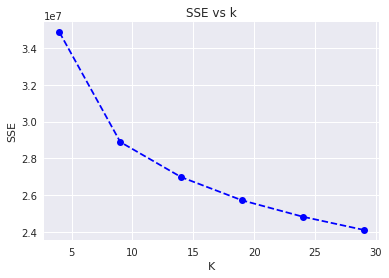

In [70]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

def get_score(df, center):
    kmeans = KMeans(center)
    model = kmeans.fit(df)
    score = np.abs(model.score(df))
    
    return score

scores = []
centers = list(range(4, 30, 5))

for c in centers:
    scores.append(get_score(pca_azdias, c))

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs k');

In [71]:
scores

[34867759.116441578,
 28889105.02427344,
 26977325.288931396,
 25712999.876722015,
 24819258.145890906,
 24101059.053202398]

In [74]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

kmeans = KMeans(20)
model = kmeans.fit(pca_azdias)
score = np.abs(model.score(pca_azdias))

In [75]:
score

25517026.063456558

In [72]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(20)
kmean_azdias = kmeans.fit(pca_azdias)
k_pre = kmean_azdias.predict(pca_azdias)


In [73]:
k_pre

array([ 1, 16, 11, ...,  4,  7, 14], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population

From the above plot we can see that the largest decrease happened in the first 3 clusters，but there is no obvious elbow.The rate of change of slope stars levelling out at 20, so I choose 20 as the no.of clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [102]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [90]:
customers.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,RELAT_AB,movement,nation,wealth,life_stage
0,4.0,1,5,1,5,1,2,2,1.0,5.0,...,3.0,3.0,5.0,5.0,1.0,1.0,2.0,3.0,1.0,3.0
1,4.0,1,5,1,5,1,3,2,1.0,3.0,...,2.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,1.0,4.0
2,4.0,2,5,1,5,1,4,4,2.0,5.0,...,2.0,3.0,3.0,2.0,3.0,3.0,2.0,3.0,3.0,4.0
3,4.0,1,5,1,5,2,1,2,2.0,3.0,...,3.0,2.0,3.0,4.0,1.0,1.0,1.0,3.0,2.0,4.0
4,3.0,1,3,1,4,4,5,2,3.0,5.0,...,2.0,4.0,3.0,3.0,3.0,1.0,1.0,3.0,4.0,1.0


In [103]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

clean_customers = clean_data(customers)

In [104]:

to_drop = []
for i in clean_customers.columns:
    if i not in scaled_azdias.columns:
        to_drop.append(i)
        
to_drop

['PLZ8_ANTG3', 'ORTSGR_KLS9']

In [105]:
for d in to_drop:
    clean_customers.drop(d, axis=1, inplace=True)

In [80]:
len(clean_customers.columns)

52

In [81]:
len(scaled_azdias.columns)

52

In [108]:
imp_customers = pd.DataFrame(imp.fit_transform(clean_customers), columns = clean_customers.columns,
                             index = clean_customers.index)

In [109]:

scaled_customers = pd.DataFrame(scaler.fit_transform(clean_customers), columns = clean_customers.columns,
                                index = clean_customers.index)

In [110]:
pca_customers = pca.fit_transform(scaled_customers)

In [111]:
kpre_customers = kmean_azdias.predict(pca_customers)

In [112]:
kpre_customers

array([ 7, 17, 10, ...,  1, 10,  9], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [113]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

cleaned_gen = azdias.shape[0]
cleaned_customers = clean_customers.shape[0]

gen_count = np.bincount(k_pre)
customers_count = np.bincount(kpre_customers)

gen_pro = [i/cleaned_gen for i in gen_count]
customers_pro = [i/cleaned_customers for i in customers_count]

In [144]:
cluster = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] 


In [145]:
all_df = pd.DataFrame({'gen':gen_pro,'customers':customers_pro,'cluster':cluster})
#cus - gen
all_df['differ_per'] = round((all_df['customers'] - all_df['gen'])*100, 2)
all_df.index.names=['cluster']

all_df

,gen,customers,cluster,differ_per
cluster,,,,
0,0.005772,0.002431,1,-0.33
1,0.084759,0.056091,2,-2.87
2,0.044164,0.244203,3,20.00
3,0.059534,0.011855,4,-4.77
4,0.043554,0.069694,5,2.61
5,0.062041,0.034030,6,-2.80
6,0.069469,0.095428,7,2.60
7,0.066894,0.088781,8,2.19
8,0.024867,0.002051,9,-2.28


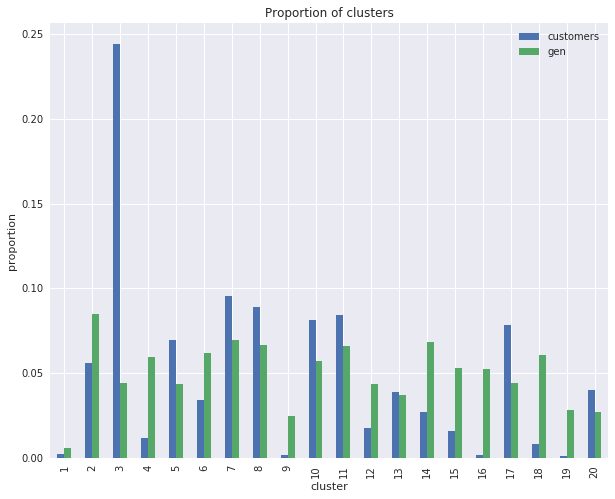

In [141]:
all_df.plot(x='cluster', y=['customers','gen'],kind='bar',figsize=(10, 8));
plt.xlabel('cluster');
plt.ylabel('proportion');
plt.title('Proportion of clusters');
plt.show();

In [147]:
count_df = pd.DataFrame({'gen':gen_count,'customers':customers_count, 'cluster':cluster})

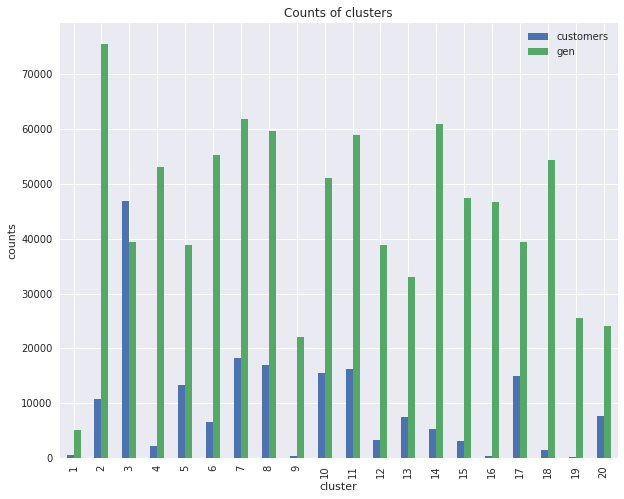

In [148]:
count_df.plot(x='cluster', y=['customers','gen'],kind='bar',figsize=(10, 8));
plt.xlabel('cluster');
plt.ylabel('counts');
plt.title('Counts of clusters');
plt.show();

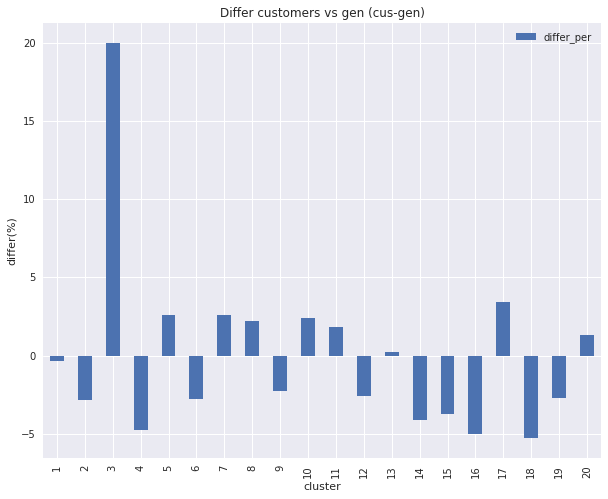

In [149]:
all_df.plot(x='cluster', y=['differ_per'],kind='bar',figsize=(10, 8));
plt.xlabel('cluster');
plt.ylabel('differ(%)');
plt.title('Differ customers vs gen (cus-gen)');
plt.show();

In [150]:
def get_counts(df):
    for i in df.columns:
        print(df[i].value_counts())

In [151]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

df = scaler.inverse_transform(pca.inverse_transform(pca_customers[np.where(kpre_customers==13)])).round()
dfc = pd.DataFrame(data=df, columns=clean_customers.columns, index=np.array(range(0, len(df))))

In [153]:
dfc.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,RELAT_AB,movement,nation,wealth,life_stage
0,4.0,1.0,5.0,1.0,5.0,2.0,1.0,3.0,2.0,5.0,...,2.0,3.0,4.0,4.0,1.0,1.0,1.0,3.0,5.0,4.0
1,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,2.0,5.0,...,2.0,3.0,5.0,5.0,3.0,5.0,2.0,2.0,5.0,4.0
2,4.0,1.0,4.0,1.0,5.0,2.0,1.0,4.0,1.0,4.0,...,3.0,1.0,3.0,4.0,1.0,1.0,1.0,3.0,3.0,4.0
3,4.0,1.0,5.0,1.0,4.0,1.0,1.0,1.0,2.0,5.0,...,3.0,1.0,3.0,3.0,4.0,3.0,1.0,3.0,1.0,4.0
4,4.0,1.0,5.0,1.0,5.0,0.0,4.0,2.0,2.0,3.0,...,4.0,2.0,3.0,4.0,3.0,5.0,2.0,3.0,4.0,3.0
5,4.0,1.0,5.0,1.0,4.0,2.0,1.0,2.0,1.0,3.0,...,3.0,2.0,3.0,4.0,4.0,3.0,1.0,3.0,4.0,3.0
6,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,2.0,5.0,...,4.0,2.0,3.0,3.0,3.0,2.0,1.0,3.0,4.0,3.0
7,4.0,1.0,4.0,1.0,5.0,1.0,2.0,4.0,1.0,3.0,...,3.0,2.0,3.0,4.0,3.0,2.0,1.0,3.0,2.0,4.0
8,4.0,1.0,5.0,1.0,5.0,1.0,1.0,3.0,2.0,3.0,...,3.0,2.0,4.0,4.0,2.0,1.0,2.0,2.0,1.0,3.0
9,4.0,1.0,3.0,1.0,5.0,1.0,1.0,4.0,2.0,5.0,...,2.0,3.0,3.0,3.0,4.0,4.0,1.0,3.0,2.0,5.0


In [152]:
get_counts(dfc)

4.0    3927
3.0    1320
Name: ALTERSKATEGORIE_GROB, dtype: int64
1.0    5010
2.0     237
Name: ANREDE_KZ, dtype: int64
5.0    2965
4.0    1482
3.0     772
2.0      28
Name: FINANZ_MINIMALIST, dtype: int64
1.0    4909
2.0     248
3.0      78
0.0      10
4.0       2
Name: FINANZ_SPARER, dtype: int64
5.0    4616
4.0     558
3.0      71
2.0       2
Name: FINANZ_VORSORGER, dtype: int64
1.0    3730
2.0    1296
3.0     156
0.0      34
4.0      30
5.0       1
Name: FINANZ_ANLEGER, dtype: int64
1.0    3469
2.0    1523
3.0     232
4.0      18
5.0       5
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
2.0    1894
4.0    1203
3.0    1041
5.0     927
1.0     182
Name: FINANZ_HAUSBAUER, dtype: int64
2.0    3404
3.0    1388
1.0     455
Name: HEALTH_TYP, dtype: int64
5.0    2785
3.0    1486
4.0     743
2.0     132
1.0     101
Name: RETOURTYP_BK_S, dtype: int64
6.0    3033
3.0    1200
4.0     856
5.0     102
2.0      46
1.0      10
Name: SEMIO_SOZ, dtype: int64
5.0    1697
4.0    1331
6.0    1261
2.0     76

This cluster seems to belong to Older families & mature couples of >60 years old, less affluent household, west and east, male, very low financial interest and are money-savers

In [154]:
df1 = scaler.inverse_transform(pca.inverse_transform(pca_azdias[np.where(k_pre==13)])).round()
dfg = pd.DataFrame(data=df1, columns=clean_customers.columns, index=np.array(range(0, len(df1))))

In [155]:
dfg.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,RELAT_AB,movement,nation,wealth,life_stage
0,4.0,1.0,4.0,-0.0,6.0,-1.0,-0.0,4.0,2.0,5.0,...,3.0,3.0,3.0,3.0,3.0,4.0,1.0,2.0,4.0,2.0
1,3.0,1.0,4.0,1.0,4.0,1.0,1.0,2.0,3.0,3.0,...,2.0,4.0,5.0,3.0,3.0,4.0,2.0,2.0,3.0,4.0
2,4.0,2.0,4.0,1.0,5.0,0.0,2.0,3.0,3.0,5.0,...,2.0,4.0,5.0,4.0,3.0,4.0,1.0,2.0,2.0,4.0
3,5.0,1.0,4.0,1.0,5.0,1.0,-0.0,3.0,2.0,5.0,...,2.0,3.0,4.0,4.0,4.0,2.0,1.0,3.0,3.0,2.0
4,4.0,1.0,5.0,-0.0,6.0,0.0,1.0,3.0,2.0,4.0,...,3.0,2.0,4.0,5.0,2.0,2.0,1.0,3.0,3.0,3.0
5,5.0,2.0,4.0,0.0,5.0,0.0,0.0,3.0,2.0,4.0,...,3.0,3.0,4.0,3.0,2.0,3.0,1.0,3.0,3.0,3.0
6,4.0,1.0,4.0,0.0,5.0,0.0,-1.0,3.0,3.0,5.0,...,3.0,2.0,3.0,3.0,4.0,4.0,1.0,2.0,3.0,3.0
7,5.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,2.0,3.0,...,2.0,3.0,3.0,4.0,3.0,3.0,2.0,3.0,6.0,3.0
8,4.0,1.0,4.0,1.0,5.0,1.0,-0.0,3.0,2.0,4.0,...,4.0,2.0,4.0,4.0,2.0,2.0,1.0,2.0,6.0,4.0
9,4.0,1.0,4.0,0.0,5.0,-0.0,0.0,4.0,2.0,5.0,...,3.0,2.0,3.0,4.0,3.0,2.0,1.0,3.0,5.0,2.0


In [156]:
get_counts(dfg)

4.0    35300
5.0    15545
3.0     9401
6.0      411
2.0      338
1.0        3
Name: ALTERSKATEGORIE_GROB, dtype: int64
1.0    36215
2.0    24702
0.0       62
3.0       19
Name: ANREDE_KZ, dtype: int64
4.0    31698
5.0    24423
3.0     3638
6.0     1208
2.0       28
7.0        3
Name: FINANZ_MINIMALIST, dtype: int64
-0.0    32993
 1.0    24999
 2.0     2104
-1.0      880
 3.0       22
Name: FINANZ_SPARER, dtype: int64
5.0    39331
6.0    12620
4.0     8643
3.0      297
7.0      105
2.0        2
Name: FINANZ_VORSORGER, dtype: int64
 0.0    28941
 1.0    25896
 2.0     3889
-1.0     2102
 3.0      168
 4.0        1
-2.0        1
Name: FINANZ_ANLEGER, dtype: int64
-0.0    28181
 1.0    21779
-1.0     6957
 2.0     3758
 3.0      168
-2.0      151
 4.0        3
-3.0        1
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
 3.0    32029
 2.0    13560
 4.0    13009
 1.0     1737
 5.0      592
 0.0       68
-1.0        3
Name: FINANZ_HAUSBAUER, dtype: int64
2.0    34478
3.0    19541
1.0     4831
4.0

4.0    24258
3.0    18509
5.0    10619
2.0     5469
6.0     1331
1.0      762
7.0       39
0.0       11
Name: wealth, dtype: int64
 3.0    26034
 2.0    17113
 4.0    11756
 1.0     3847
 5.0     1662
 0.0      343
 6.0      196
 7.0       27
-1.0       19
 8.0        1
Name: life_stage, dtype: int64


This cluster seems to belong to Families with school-age children,>60 years old, less affluent household, west and east, high money-saver.

In [157]:
df2 = scaler.inverse_transform(pca.inverse_transform(pca_customers[np.where(kpre_customers==14)])).round()
dfc2 = pd.DataFrame(data=df2, columns=clean_customers.columns, index=np.array(range(0, len(df2))))

In [158]:
dfc2.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,RELAT_AB,movement,nation,wealth,life_stage
0,2.0,1.0,2.0,4.0,3.0,3.0,3.0,3.0,1.0,3.0,...,1.0,3.0,3.0,1.0,3.0,5.0,1.0,3.0,4.0,1.0
1,2.0,1.0,3.0,2.0,4.0,1.0,2.0,2.0,2.0,3.0,...,2.0,4.0,3.0,3.0,4.0,4.0,2.0,2.0,4.0,5.0
2,3.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,3.0,5.0,...,2.0,3.0,3.0,3.0,4.0,5.0,2.0,3.0,1.0,5.0
3,3.0,1.0,4.0,1.0,5.0,1.0,1.0,5.0,3.0,5.0,...,1.0,4.0,5.0,4.0,3.0,3.0,2.0,3.0,4.0,1.0
4,3.0,1.0,2.0,4.0,2.0,4.0,5.0,2.0,1.0,1.0,...,3.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,4.0,3.0
5,1.0,1.0,2.0,4.0,1.0,4.0,3.0,4.0,3.0,3.0,...,1.0,1.0,5.0,2.0,4.0,3.0,1.0,3.0,4.0,1.0
6,3.0,1.0,5.0,2.0,4.0,1.0,2.0,1.0,1.0,5.0,...,2.0,3.0,3.0,3.0,2.0,3.0,2.0,3.0,2.0,4.0
7,3.0,1.0,5.0,2.0,4.0,2.0,2.0,1.0,3.0,3.0,...,2.0,3.0,4.0,3.0,3.0,5.0,1.0,3.0,1.0,3.0
8,1.0,1.0,2.0,4.0,2.0,4.0,5.0,3.0,2.0,4.0,...,1.0,4.0,3.0,3.0,3.0,5.0,2.0,3.0,5.0,4.0
9,1.0,1.0,2.0,4.0,2.0,3.0,3.0,3.0,1.0,4.0,...,1.0,4.0,5.0,3.0,3.0,5.0,2.0,3.0,3.0,4.0


In [159]:
get_counts(dfc2)

3.0    1429
2.0     737
1.0     695
4.0     170
Name: ALTERSKATEGORIE_GROB, dtype: int64
1.0    3023
2.0       8
Name: ANREDE_KZ, dtype: int64
3.0    1022
4.0     895
5.0     492
2.0     461
1.0     161
Name: FINANZ_MINIMALIST, dtype: int64
1.0    1286
4.0     696
2.0     573
3.0     360
5.0     116
Name: FINANZ_SPARER, dtype: int64
5.0    1290
4.0     708
2.0     575
3.0     283
1.0     174
6.0       1
Name: FINANZ_VORSORGER, dtype: int64
1.0    1457
2.0     584
3.0     467
4.0     339
5.0     105
0.0      73
6.0       6
Name: FINANZ_ANLEGER, dtype: int64
2.0    861
1.0    823
3.0    633
5.0    396
4.0    306
6.0     11
0.0      1
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
2.0    814
3.0    769
5.0    632
4.0    610
1.0    206
Name: FINANZ_HAUSBAUER, dtype: int64
3.0    1810
2.0     789
1.0     432
Name: HEALTH_TYP, dtype: int64
5.0    1428
3.0     867
4.0     465
1.0     236
2.0      35
Name: RETOURTYP_BK_S, dtype: int64
7.0    1294
6.0     884
3.0     499
4.0     346
2.0       4
5.0 

This cluster seems belong to Pre Family couples & singles, 46 - 60 years old, less affluent household, west and east, money-saver.

In [160]:
df3 = scaler.inverse_transform(pca.inverse_transform(pca_azdias[np.where(k_pre==14)])).round()
dfg3 = pd.DataFrame(data=df3, columns=clean_customers.columns, index=np.array(range(0, len(df3))))

In [161]:
dfg3.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,RELAT_AB,movement,nation,wealth,life_stage
0,2.0,0.0,4.0,4.0,3.0,4.0,5.0,3.0,2.0,3.0,...,1.0,3.0,4.0,2.0,3.0,4.0,2.0,3.0,4.0,3.0
1,3.0,2.0,4.0,3.0,3.0,3.0,4.0,3.0,2.0,5.0,...,1.0,2.0,3.0,2.0,3.0,3.0,2.0,2.0,4.0,2.0
2,4.0,1.0,3.0,3.0,3.0,3.0,3.0,4.0,2.0,5.0,...,1.0,4.0,3.0,2.0,4.0,5.0,2.0,3.0,3.0,4.0
3,3.0,1.0,2.0,3.0,4.0,2.0,4.0,5.0,2.0,3.0,...,2.0,3.0,3.0,3.0,3.0,5.0,2.0,3.0,3.0,3.0
4,2.0,1.0,4.0,2.0,4.0,2.0,2.0,3.0,2.0,3.0,...,2.0,5.0,3.0,2.0,4.0,4.0,2.0,3.0,3.0,3.0
5,3.0,1.0,4.0,3.0,4.0,2.0,4.0,2.0,2.0,1.0,...,2.0,3.0,2.0,2.0,3.0,4.0,2.0,3.0,1.0,4.0
6,2.0,1.0,3.0,3.0,4.0,3.0,4.0,4.0,1.0,3.0,...,2.0,2.0,3.0,3.0,3.0,6.0,1.0,3.0,3.0,4.0
7,3.0,1.0,3.0,3.0,3.0,4.0,4.0,4.0,2.0,5.0,...,2.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0
8,3.0,1.0,4.0,3.0,4.0,2.0,3.0,3.0,2.0,5.0,...,1.0,4.0,4.0,3.0,4.0,3.0,2.0,3.0,3.0,4.0
9,2.0,0.0,4.0,3.0,4.0,2.0,4.0,2.0,3.0,6.0,...,1.0,4.0,3.0,2.0,3.0,5.0,1.0,3.0,3.0,2.0


In [162]:
get_counts(dfg3)

2.0    22011
3.0    17952
1.0     5505
4.0     1771
0.0      137
5.0        7
Name: ALTERSKATEGORIE_GROB, dtype: int64
1.0    42812
0.0     3398
2.0     1173
Name: ANREDE_KZ, dtype: int64
3.0    24252
4.0    16541
5.0     3456
2.0     3104
6.0       26
1.0        4
Name: FINANZ_MINIMALIST, dtype: int64
3.0    27206
2.0    15015
4.0     3525
1.0     1618
5.0       17
9.0        1
0.0        1
Name: FINANZ_SPARER, dtype: int64
 4.0    26662
 3.0    13650
 5.0     6383
 2.0      625
 6.0       58
 7.0        2
 1.0        2
-3.0        1
Name: FINANZ_VORSORGER, dtype: int64
3.0    23638
2.0    15768
4.0     6338
1.0     1436
5.0      194
0.0        8
6.0        1
Name: FINANZ_ANLEGER, dtype: int64
3.0    18362
4.0    15276
2.0     7292
5.0     5598
6.0      465
1.0      382
0.0        4
7.0        3
9.0        1
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
 3.0    19599
 4.0    18736
 2.0     6159
 5.0     2043
 1.0      809
 0.0       23
 6.0       13
-3.0        1
Name: FINANZ_HAUSBAUER, d

This cluster seems belong to Older families & mature couples, <46 years old, male, low financial interest, comfortable household, west and east

### Discussion 3.3: Compare Customer Data to Demographics Data


To see which features mostly define the each cluster , I took the inverse_transformation of the PCA,to back the original features.  It is easier to interpret than the principal components. In the customer data, the culsters 3 and 7 account for the highest proportion. In general population data, clusters 2 and 7 appear to be closely represented.

From the plot above,I think the company can use this information to select a category of the general population for business. Considering the fact that we have removed 33 columns, which are mixed and multi features, and contain important information. If we maintain these characteristics, we will see a better match between the general and customer population.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.